<h1><center>DATA ACQUISITION</center></h1>

This project aims to analyze movie data from IMDB database based on 3 categories (commercial, critical and financial) and predict the nominees and winners for the The 92<sup>nd</sup> Academy Awards due to be held in 2020. 

The Data Acquisition phase will comprise of 3 steps:
1. To obtain a list of English language films betwen the year 1955 to 2019
2. To obtain the complete list of Academy Award winners and nominees, both in the film and individual categories

By acquiring the latest and most updated data about films from **Wikipedia** and **IMDB** website of Hollywood films from 1940 to 2019, we will attempt to identify the key features that make films successful, popular and enduring. 

We will look at three key parameters:
1. Accolades given by The Academy of Motion Pictures
2. Box office revenues
3. IMDB ratings based on fan reviews

Based on these outcomes, we will explore the history of hollywood films and The Academy Awards to see what makes movies resonate with fans and endure over time. Why do some films become commercially successful but fail to win critical acclaim? Is there a correlation between budget and box-office revenues - do big budget moviesd make more money? Is there any significant correlation between how fans and the Academy view a film's success? 

By pooling data from various sources, defining metrics and measures that are simple and intuitive, we will try to uncover the secrets of great films. Using this knoweldge and information, we will try to predict the nominees and winners for the upcoming Oscars due to be held in 2020. 

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import requests
import wikipedia
import re
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from urllib.request import urlopen
from scrapy import selector
import datetime as dt
import pickle
from skimage import io
from IPython.display import clear_output
import pdb

# 1.0 Obtaining Movie List and Creating Initial Database

For the project of analyzing movie success and predicting the Academy Award winner for the year 2020, our first step was to obtain a list of all major English films made between the years 1950 to 2019. In order to do that, we looked at the List of American abd British films made in each year in that period. 

In [3]:
%%time
primary_list = []
for year in range(1950,2020):
    if year%10==0:
        print(f"In the {year}'s")
    # Set URL
    my_url = ['List_of_American_films_of_'+ str(year), 'List_of_British_films_of_'+ str(year)]
    
    #Define empty list for the year
    
    for url in my_url:
        page = wikipedia.page(url)
        soup = BeautifulSoup(page.html(),'lxml')
        tables = soup.find_all('table', class_ = 'wikitable') # , class_="wikitable sortable jquer-tablesorter")
        movie_set_us = []
        for table in tables:
            films = table.find_all('i')
            for film in films:
                title = film.text
                # print(title)
                link = film.find_all('a', href=True, title = True)
                if len(link)==0:
                    continue
                else:
                    link = link[0]['href']
                primary_list.append((year,film.text,link))

        
pickle.dump(primary_list,open( 'my_data_3/PRIMARY_LIST', "wb" ))
len(primary_list)


In [250]:
primary_list[4566]

(1971, 'McCabe & Mrs. Miller', '/wiki/McCabe_%26_Mrs._Miller')

# The Wikipedia API

The API consists of a collection of functions for standardizing budget (to US million dollars) and prediceded genres so that final Dataframes are all consistent.

The following functions are defined below:
1. wikiapi_film(title, year): returns **intro** and **infobox** HTML from wikipedia page
2. get_genre(intro): Scrapes the intro paragraph of the wikipedia page and identifies genres
3. movie_info_dict(infobox): returns dictionary with all the information

In [2]:
## WIKIPEDIA API Function

# Define function fr obtaining movie data using Wikipedia API
def wikiapi_film(title, year):   
    '''Takes in a title, award and year, and returns the the wikipedia.page containing HTML
    ''' 
    if len(title)==0 or len(str(year)) == 0:
        return 
    
    title_with_date = title + f' ({year}_film)'
    try:
        print(title_with_date)
        if wikipedia.page(title_with_date)!=None:
            return wikipedia.page(title_with_date)
    except wikipedia.exceptions.DisambiguationError:
        pass
    except wikipedia.exceptions.PageError:
        pass

    title_without_date = title + ' (film)'
    try:
        print(title_without_date)
        if wikipedia.page(title_without_date) != None:
            return wikipedia.page(title_without_date)
        if page==None:
            try:
                return wikipedia.page(title)
            except wikipedia.exceptions.PageError:
                print(f"Warning: The Wikipedia page for the title {title} could not be found without date ")
   
    except wikipedia.exceptions.DisambiguationError:
        print(f"\tToo many pages for the title {title}: could not fetch information")
        return 
    except wikipedia.exceptions.PageError:
        print(f"\tThe Wikipedia page for the title {title} could not be found ")
        return 

In [3]:
# Get the standardized genre specified in genre_dict file
genre_dict = {
        'romance': 'rom','romantic': 'rom','comedy': 'com','musical':'mus',
        'animated':'ani','superhero':'sup','horror':'hor','crime': 'cri',
        'war ':'war','psychological':'psy','psychology':'psy','action':'act',
        'dystopian':'dys','political':'pol','spy':'spy','science': 'sci',
        'adventure':'adv','fantasy': 'fan','biography': 'bio','biographical': 'bio',
        'historical':'his','mystery':'mys','epic':'epi','thrill':'thr','drama':'dra',
        'monster': 'mon','disaster':'dis','other':'oth'
    }
pickle.dump(genre_dict,open( 'my_data_3/genre_dict', "wb" ))


In [4]:
def get_genre(intro):
    """returns the movie genre based on wikipedia intro, returns list of genres
    """
    genre_dict = pickle.load(open("my_data_3/genre_dict","rb"))
    this_movie_genres = []
    for line in intro: # got through all the lines
        line = line.text.split('.')
        line = line[0]
        line = line.lower()
        for genre in genre_dict:
            if line.find(genre) > 0:
                this_movie_genres.append(genre_dict[genre])
        
        if len(this_movie_genres)>0:
            return list(set(this_movie_genres))
    return ['other']

In [5]:
# Create dictionary from Wikipedia page of the film using the INFOBOX table

def movie_infobox_dict(infobox_items, intro):
    """Accepts an infobox item and intro sections of wikipedia page and returns a dictionary
    """
    # initialiZe empty dictionary
    movie_dict = dict()
    
    # Go through each infobox item and extract information
    for item in infobox_items:
        try:
            if len(item) < 2:
                continue
            
            #director
            if item.th.text.lower().find('direct')>-1:
                movie_dict['director'] = []
                if item.td.find('div', class_="plainlist")==None: # single entries
                    for line in item.td.find_all('a'):
                        movie_dict['director'].append(line.text)      
                else:
                    for line in item.td.find('div', class_="plainlist").find_all('li'):
                        movie_dict['director'].append(line.text)
                if len(movie_dict['director'])==0:
                    movie_dict['director'] = item.td.text.split('br')
            #producer
            if item.th.text.lower().find('produce')>-1:
                movie_dict['producer'] = []
                if item.td.find('div', class_="plainlist")==None: # single entries
                    for line in item.td.find_all('a'):
                        movie_dict['producer'].append(line.text)    
                else:
                    for line in item.td.find('div', class_="plainlist").find_all('li'):
                        movie_dict['producer'].append(line.text) 
                if len(movie_dict['producer'])==0:
                    movie_dict['producer'] = item.td.text.split('br')

            #cast
            if item.th.text.lower().find('star')>-1:
                movie_dict['cast'] = []
                if item.td.find('div', class_="plainlist")==None: # single entries
                    for line in item.td.find_all('a'):
                        movie_dict['cast'].append(line.text)
                else:
                    for line in item.td.find('div', class_="plainlist").find_all('li'):
                        movie_dict['cast'].append(line.text)
                if len(movie_dict['cast'])==0:
                    movie_dict['cast'] = item.td.text.split('br')

            #screenplay
            if item.th.text.lower().find('screenplay')>-1 or item.th.text.lower().find('written')>-1:
                movie_dict['screenplay'] = []
                if item.td.find('div', class_="plainlist")==None: # single entries
                    for line in item.td.find_all('a'):
                        movie_dict['screenplay'].append(line.text)
                else:
                    for line in item.td.find('div', class_="plainlist").find_all('li'):
                        movie_dict['screenplay'].append(line.text)
                if len(movie_dict['screenplay'])==0:
                    movie_dict['screenplay'] = item.td.text.split('br')

            #cinematography
            if item.th.text.lower().find('cinematography')>-1:
                movie_dict['cinematography'] = []
                if item.td.find('div', class_="plainlist")==None: # single entries
                    for line in item.td.find_all('a'):
                        movie_dict['cinematography'].append(line.text)
                else:
                    for line in item.td.find('div', class_="plainlist").find_all('li'):
                        movie_dict['cinematography'].append(line.text)
                if len(movie_dict['cinematography'])==0:
                    movie_dict['cinematography'] = item.td.text.split('br')

            # music
            if item.th.text.lower().find('music')>-1 or item.th.text.lower().find('score')>-1:
                movie_dict['music'] = []
                if item.td.find('div', class_="plainlist")==None: # single entries
                    for line in item.td.find_all('a'):
                        movie_dict['music'].append(line.text)
                else:
                    for line in item.td.find('div', class_="plainlist").find_all('li'):
                        movie_dict['music'].append(line.text)
                if len(movie_dict['music'])==0:
                    movie_dict['music'] = item.td.text
                
            # editing
            if item.th.text.lower().find('edit')>-1:
                movie_dict['edit'] = []
                if item.td.find('div', class_="plainlist")==None: # single entries
                    for line in item.td.find_all('a'):
                        movie_dict['edit'].append(line.text)
                else:
                    for line in item.td.find('div', class_="plainlist").find_all('li'):
                        movie_dict['edit'].append(line.text)
                if len(movie_dict['edit'])==0:
                    movie_dict['edit'] = item.td.text.split('br')

            # Based on a book (Y/N)
            if item.th.text.lower().find('based')>-1:
                movie_dict['book'] = 'yes'

            # Get budget
            if item.th.text.lower().find('budget')>-1:
                budget = item.td.text.strip()
                budget = re.sub(r'\[.+\]+', "", budget) #remove square bracket references
                movie_dict['budget'] = currency_to_million(budget)

            # Get box office
            if item.th.text.lower().find('box')>-1:
                box_office = item.td.text.strip()
                box_office = re.sub(r'\[.+\]+', "", box_office)#remove square bracket references
                movie_dict['box_office'] = currency_to_million(box_office)

            # Get running time
            if item.th.text.lower().find('running time')>-1:
                running_time = item.td.text.strip()
                running_time = re.findall(r'(\d+)\smin', running_time)
                if len(running_time)==0:
                    movie_dict['running_time'] = 0
                    continue
                movie_dict['running_time'] = int(running_time[0])

            # Language 
            if item.th.text.lower().find('language')>-1:
                language = item.td.text.strip()
                if (language.lower().find('english') == -1 and 
                    language.lower().find('silent') == -1): # film does not contain english
                    return dict()
                movie_dict['language']= language.split('\n')

            # Release date 
            if item.th.text.lower().find('release')>-1:
                release = item.td.text.strip()
                release = re.findall(r'\d\d\d\d', release)
                release = dt.datetime.strptime(release[0], '%Y').year
                if len(str(release))==0:
                    continue
                movie_dict['year']=release
            
            
            # Get genre
            movie_dict['genre'] = get_genre(intro)

        except AttributeError:
            print(f'\tCould not fetch info for {title} from infobox items')

    return movie_dict


# Converts different denominations to $X.y million
def currency_to_million(money):
    ''' Accepts $12 million and returns 12000000
        Accepts $13,678,654 and reurns  13678654
        Accept $15-25 million and returns 25000000
        Accepts $2 billion and returns 2000000000
        using regular expressions
    '''
    if money == None:
        return np.nan
    if len(money)==0:
        return np.nan

    # Check to see dollar, otherwise return nan
    money = money.lower()
    if money.find('$')>-1:
        factor=1
    elif money.find('£')>-1:
        factor = 1.3
    else:
        return np.nan
    
    money = re.sub(r'\[.*\]', '', money) #remove square bracket citation

    if money.find('illion')>0: # when currency expressed in million/billion

        # Billion: $12.4 billion
        reg = r"[\$-–]([0-9.]+)\sbillion"
        num = re.findall(reg, money) # find number like $12.4 billion
        if len(num)>0:
            # num = re.sub(r'\D', "", num) # drop any non-numeric characters like comma, dash etc
            return  round(float(num[0])*1e3*factor,2)

        # Million: $6.8 million
        reg = r"[\$-–]([0-9.]+)\smillion"
        num = re.findall(reg, money) # find number like $6.8 million
        if len(num)>0:
            # num = re.sub(r'\D', "", num) # drop any non-numeric characters like comma, dash etc
            try:
                return round(float(num[0])*factor,2)
            except:
                return np.nan

    else: # When currency not expressed in millions  
        reg = r"[$£]\s?([\d,]+)[\D\s]?"
        num = re.findall(reg, money)
        if len(num) >0:
            num = re.sub(r',', '', num[0])
            try:
                return round(float(num)/1e6*factor,2)
            except:
                return np.nan


In [6]:
# This is the main function that calls wikiapi_film, OMDB API and ancillary functions to get the dictionaries
def get_all_movie_info(title, year):
    """This is the MAIN function that uses previous functions to accept title and year and return 
    all the movie information, returns dictionary
    """
    
    # Wikipedia info
    page = wikiapi_film(title, year)
    if page == None:
        return dict()

    soup = BeautifulSoup(page.html(),'html5lib') 
    
    # Get wikipedia introduction paragraph for genres
    try:
        intro = soup.find_all('p')
    except:
        print(f'Could not find p-tags info for {title}')
        return dict()
    
    # Get wikipedia infobox tables for all other information
    try:
        infobox_items = soup.find('table', class_ = 'infobox vevent').tbody.find_all('tr')
    except: 
        print(f'Could not find infobox for {title}')
        return dict()
        
    this_dict = movie_infobox_dict(infobox_items, intro) # get movie info dictionary

    # obtain json file from OMDB API and get info
    url_base = 'http://www.omdbapi.com/?i=tt3896198&apikey=5db77b44&'
    url = url_base + 't=' + str(title)
    r = requests.get(url)
    json_data = r.json()
    if 'Error' in json_data:
        print(f'\t{title} not found in OMDB API')
        return dict()
    try:
        this_dict['imdbID'] = json_data['imdbID']
        this_dict['imdb_rating'] = float(json_data['imdbRating'])
        this_dict['n_votes'] = int(re.sub(r',','',json_data['imdbVotes']))
        this_dict['title'] =title
    except:
        print(f'Unknown error in {title}: could not fetch info')
        return dict()
    
    return this_dict

In [12]:
%%time
# Get movie_dict and SAVE
# df_imdb was created in an older version of the 
df_imdb = pd.read_csv('my_data_3/df_imdb.csv')
df_imdb.reset_index()
print(df_imdb.shape)
movie_dict = dict()
for row in df_imdb.iterrows():
    if row[0]%20==0:
        clear_output()
        print(f'{row[0]} of {len(df_imdb)}')
    title = row[1].title.lower()
    year = row[1].year
    movie_dict[(title,year)] = get_all_movie_info(title, year)

#SAVE movie_dict
pickle.dump(movie_dict,open( 'my_data_3/movie_info_dict', "wb" ))

5880 of 5886
a better life (2011_film)
two days, one night (2014_film)
the book thief (2013_film)
anna karenina (2012_film)
the artist (2011_film)
twice in a lifetime (1985_film)
CPU times: user 26min 8s, sys: 58.6 s, total: 27min 7s
Wall time: 5h 6min 41s


In [107]:
##########GET 2019 moives ##########
movie_dict_2019 = dict()
df = df_movies[df_movies.year==2019]
for row in df.iterrows():
    if row[0]%20==0:
        clear_output()
        print(f'{row[0]} of {len(df_imdb)}')
    title = row[1].title.lower()
    year = row[1].year
    if year!=2019:
        continue
    movie_dict_2019[(title,year)] = get_all_movie_info(title, year)

#SAVE movie_dict
pickle.dump(movie_dict_2019,open( 'my_data_3/movie_info_dict', "wb" ))


(5886, 10)

In [109]:
# #SAVE movie dict
# reject = [];
# for movie,year in movie_dict:
#     if len(movie_dict[movie,year])==0:
#         # print(year)
#         reject.append(movie)
# movie_dict[("moneyball",2011)]


In [31]:
def create_dataframe_from_dict(movie_dict, all_columns):
    """Accept the movie_info_dict and creates the DataFrame 
    containing budget, box_office, running_time, cast etc (mentioned in columns)
    Returns a dataframe
    """

    df = pd.DataFrame()
    rejects = []
    for i,(title,year) in enumerate(movie_dict):
        print(title)
        if i%50 == 0:
            clear_output()
        
        movie = movie_dict[title,year]
        if len(movie)==0:
            print(f'\tCould not prepare DataFrame for {title}. Movie info missing!')
            continue
            
        for col in all_columns:
            # print(i,title)
            if col in movie:
                if type(movie[col])!=list:
                    df.loc[i,col] = movie[col]
                elif type(movie[col])==list:
                    df.loc[i,col] = len(movie[col])
            else:
                rejects.append(title)
                
    return df, list(set(rejects))

In [32]:
# Create DataFrame and SAVE as df_movies
columns = ['imdbID','title','year','n_votes','imdb_rating','budget', 'box_office','cast','running_time']
df_movies, rejected = create_dataframe_from_dict(movie_dict, columns)
print(df_movies.shape)
df_movies = df_movies.dropna()
print('after dropna()',df_movies.shape)
print('Done!')

# Convert year column from integer to date_time and SAVE
# yr_column = pd.to_datetime(df_movies.year.astype('int'), format='%Y')
df_movies.year = [y.year for y in pd.to_datetime(df_movies.year.astype('int'), format='%Y')]
df_movies.to_csv('my_data_3/df_movies')

i am love
sunrise at campobello
the shop on main street
coco before chanel
madame bovary
beach red
the facts of life
closer
and now my love
papa's delicate condition
pieces of dreams
the little ark
sunset
shanks
the young land
youth
mohammad, messenger of god
jim: the james foley story
the return of martin guerre
kisses for my president
babel
yes, giorgio
silence
faces
the pigeon that took rome
oscar and lucinda
malèna
banning
the godfather part ii
a better life
two days, one night
the book thief
anna karenina
the artist
twice in a lifetime
(5533, 9)
after dropna() (4830, 9)
Done!


In [97]:
df_movies.sort_values(by='budget', ascending=False).head()

,imdbID,title,year,n_votes,imdb_rating,budget,box_office,cast,running_time
5366,tt0104740,little nemo: adventures in slumberland,1989,6370.0,7.2,3000.0,11.4,3.0,95.0
5135,tt1517260,the host,2006,107076.0,5.9,1800.0,89.4,5.0,119.0
7,tt1229238,mission: impossible,1996,435418.0,7.4,828.0,3570.0,1.0,769.0
21,tt2395427,avengers: age of ultron,2015,688839.0,7.3,495.2,1403.0,17.0,141.0
152,tt0986233,hunger,2012,62427.0,7.6,495.0,2970.0,9.0,548.0


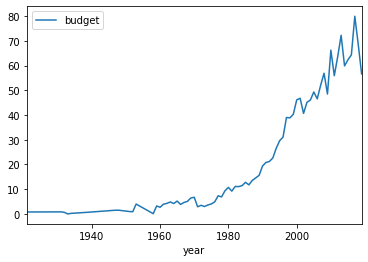

In [73]:
df = df_movies[(df_movies.budget<500)&(df_movies.box_office < 5000)&(df_movies.n_votes > 1000)]
df.head()
x = df[['year','budget']].groupby(['year']).mean().reindex()
# x.plot.scatter(x = 'year', y='budget', c='DarkBlue')
x.plot(kind='line')

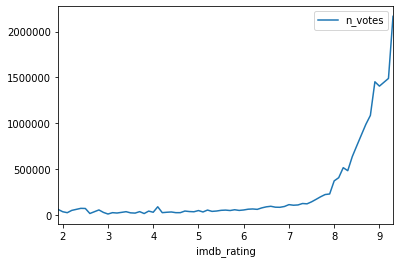

In [86]:
x = df[['imdb_rating','n_votes']].groupby(['imdb_rating']).mean().reindex()
x.plot(kind='line')

# df.plot.scatter(x = 'imdb_rating', y = 'n_votes', c='DarkBlue')

In [77]:
df.sort_values(by='n_votes', ascending=True).head()

,imdbID,title,year,n_votes,imdb_rating,budget,box_office,cast,running_time
5470,tt0053334,tarzan's greatest adventure,1959,1001.0,6.6,0.75,1.0,7.0,88.0
3301,tt4002772,once(i),2007,1001.0,6.2,0.15,23.3,2.0,86.0
3022,tt0071788,macon county line,1974,1021.0,6.6,0.23,30.0,8.0,89.0
5054,tt0057556,"take her, she's mine",1963,1027.0,6.4,2.44,3.4,2.0,98.0
5461,tt0055988,five weeks in a balloon,1962,1028.0,5.8,2.37,1.2,14.0,101.0


# 2.0 Data Acquisition for Academy Awards with Webscraping and API
<a id="acquisition"></a>

We will use BeautifulSoup for web-scraping together with the wikipedia API to obtain information about the most popular films released between 1960 and 2019 and the various Academy Awards nominations and wins during that period. Out goal is to look at hollywood films under three categories of performance: awards, critical review and revenue to identify what predicts the success of a movie. 

In other words, we see each film in terms of its measurable and identifiable features and see hwo they contributed to the success of a movie. Are big budget movies more likely to win awards? Is it the size or profile of the cast size that are likely to draw a more critically acclaim? Are longer movies more popular among the award committe and the fans alike?

In order to obtain clean and reliable movie information and their awards and nomination in the different film categories, we use two APIs: the wikiedpa API and the omdb API. 

We also use the BeautifulSoup module aloing with regular expressions (re) to extract the various information from wikipedia and IMDB to obtain the most reliable information about films. 

## 2.2 Web scraping from Wikipedia

The following function obtained information about a film, namely its director, cast, running time, budget and box office information as shown below for Lawrence of Arabia (1962), which was used for predicting the Oscars for 2020. 
The information is returned as a Python dictionary.
<br>
<img src="files/wiki4.png" height="100" width="100" align="left" style="width:40%">
<img src="files/wiki2.png" height="100" width="100" align="center" style="width:40%">


## 2.1 The Wikipedia API
The following function accepts a title, year or category and obtains the HTML document for the relevant wikipedia page. 

The wikpedia pages for the Academy Awars expect get request not in the specification of year (eg. 1974 Academy Awards), but in the form of "N<sup>th</sup> Academy Awards, such as <a href="https://en.wikipedia.org/wiki/34th_Academy_Awards">"34th Academy Awards"</a>". The same wikipedia API can can individual film information if movie and year are specified, and The Academy Awards information for a given year as shwon below.
<br>

#### Getting Oscar Editions
The Wikipedia page for The Academy Awards is referenced **not** by the year (eg. 1962 Academy Awards) but by its edition (34th Academy Awards) as shown below. 
<br>
<img src="files/wiki.jpeg" height="800" width="800" align="left">

In [87]:
# The Wikipedia pages for Academy Awards are listed in terms of their edition: 1st, 2nd, 3rd, etc.


def wikiapi_nth(year, award = ' Academy Awards'):
    year =get_edition(year)
    year_award_wikiformat = year + award
    try:
        return wikipedia.page(year_award_wikiformat)
    except wikipedia.exceptions.PageError:
        pass
    
    try:
        return wikipedia.page(year_award_wikiformat.replace(' ','_'))
    except wikipedia.exceptions.PageError:
        print(f"The page for the year {year_award_wikiformat} could not be found ")
        return

########################################################
def get_edition(year):
    '''Takes in a year and returns the edition of the given year's oscars
    eg: Academy Awards, 1930 and returns 2nd Academy Awards'''
    
    # Define editiona
    editions = ['th','st', 'nd', 'rd','th', 'th', 'th', 'th', 'th', 'th', 'th']
    # editions_dict = {}
    nth = year - 1928
    if nth>10 and nth<20:
        year_th = str(nth)+'th'
    else:
        year_th = str(nth) + editions[nth%10]
    return year_th


#########################################################
def get_genre(intro):
    """Takes in the intro paragraph from Wikipedia and scrapes out information about genre
    """
    genre_dict = pickle.load(open("my_data_2/genre_dict","rb"))
    this_movie_genres = []
    for line in intro: # got through all the lines
        line = line.text.split('.')
        line = line[0]
        line = line.lower()
        for genre in genre_dict:
            if line.find(genre) > 0:
                this_movie_genres.append(genre_dict[genre])
        
        if len(this_movie_genres)>0:
            return list(set(this_movie_genres))
    return 


In [88]:
# Prediceded list of award categories
main_categories = ['picture','director','s_actor','s_actress','actor', 
                   'actress','screenplay','music','cinematography',
                   'editing','effects','sound','costume', 
                   'song', 'art_direction']
pickle.dump(main_categories,open( 'my_data_3/main_categories', "wb" ))


In [89]:
print(main_categories)
def get_main_category(category):
    """This function accepts variants of basic cateries such as 
    'Best Motion Picture' and 'Best Picture' and 'Outstanding Picture'
    and returns "picture"
    """
    category = category.lower()

    if category.find('story')>=0:
        return 'other'
    if category.find('best picture')>=0 or category.find('best motion picture')>=0:
        return 'picture'
    if category.find('outstanding production')>=0 or category.find('outstanding picture')>=0:
        return 'picture'
    if category.find('actor')>=0:
        if category.find('supporting')>=0:
            return 's_actor'
        else:
            return 'actor'   
    if category.find('actress')>=0:
        if category.find('supporting')>=0:
            return 's_actress'
        else:
            return 'actress'    
    if category.find('best director')>=0:
        return 'director'
    if category.find('screenplay')>=0:
        return 'screenplay'
    if category.find('music')>=0 or (category.find('scor')>=0):
        return 'music'
    if category.find('costume')>=0:
        return 'costume'
    if category.find('editing')>=0:
        return 'editing'
    if category.find('effects')>=0:
        return 'effects'
    if category.find('cinematography')>=0:
        return 'cinematography'
    if category.find('sound')>=0:
        return 'sound'
    if category.find('song')>=0:
        return 'song'
    if category.find('art')>=0 and category.find('direct')>=0:
        return 'art_direction'
    # if category.find('art direction')>=0:
        # return 'art direction'
    else:
        # print(f'Warning:{category} did not get matched!')
        return 'other'

['picture', 'director', 's_actor', 's_actress', 'actor', 'actress', 'screenplay', 'music', 'cinematography', 'editing', 'effects', 'sound', 'costume', 'song', 'art_direction']


## Film Awards and Nominations
The following function obtains movie information at the level of the mlovie and NOT the individual winners.

In [90]:
# Awards and Nominations
def awards_and_nominations(year, award = ' Academy Awards', all_categories = 'all'):
    '''This function accepts year, title or award and goes into the wikipedia page of the Award 
    or the Movie and extrac t all the necessary information.
    '''
    
    if all_categories=='all':
        all_categories = pickle.load(open("my_data_3/main_categories","rb")) 

    
    # initialize empty DataFrame and the corresponding Screening Number
    oscars_wn = pd.DataFrame()
    missing_categories = []
    winner_list = dict()
    nominee_list = dict()
    
    # Get the html file from the Wikipedia page using the wikipedia API.
    # Parse it with BeautifulSoup
    page = wikiapi_nth(year)
    soup = BeautifulSoup(page.html(),'lxml')
    print(get_edition(year))
        
    # Get the table-body (tbody) from the wikipedia page where Oscars information are stored
    tbody = soup.body.find('table', class_="wikitable").find('tbody')
       
    # Make sure number of cells and header match
    if len(tbody.find_all('td')) !=len(tbody.find_all(['div', 'th'])):
    
        # The wikipedia tables needs to be fixed! Some category header may be missing.
        print('Warning: Number of cell <td> element  and header <th> does not add up for year:', year)
        print('Returned Empty dataFrame')
        return oscars_wn, missing_categories
        
        
    # Get winners and nominees
    try:
        for td,th in zip(tbody.find_all('td'),tbody.find_all(['div', 'th'])):
            cat = th.text.strip()
            # Get standardized categories
            category = get_main_category(cat)
            if category not in all_categories:
                continue
            winner_list[category] = [] # inditialize an empty dictionary
            nominee_list[category] = []

            if category=='other':
                missing_categories.append(cat)
                # print(f'Warning in {category} in {year}')

            # Go into the list and look at every line
            for tli in td.find_all('li'):
                # go down each line (li) and check if it is bolded
                if tli.find('b')!= None: # winner
                    winner = tli.find('i').text.strip()       # get italicized movie
                    winner = re.sub(r'–',"", winner).strip()
                    winner = winner.lower()
                    winner_list[category].append(winner) # add movie to winner list
                    oscars_wn.loc[winner,'year']= int(year)-1
                    oscars_wn.loc[winner,category]='W'
                    
                elif tli.find('b')== None: #nominee
                    nominee = tli.find('i').text.strip()      # get italicized movie
                    nominee = re.sub(r'–',"", nominee).strip()
                    nominee = nominee.lower()
                    nominee_list[category].append(nominee)
                    oscars_wn.loc[nominee,'year']= int(year)-1
                    if nominee in winner_list[category]: # if same movie has already won, leave it unchanged as 'W'
                        oscars_wn.loc[nominee,category]='WN'
                    else:
                        oscars_wn.loc[nominee,category]='N'

        
    except AttributeError:
        print(f'Warning: in Category {category} for Year: {year}')
            

    # oscars_wn['film'] = oscars_wn.index
    return oscars_wn.fillna('O'), missing_categories

In [92]:
# GET MOVIE AWARDS FROM ALL CATEGORIES
df_oscars = pd.DataFrame()
for year in range(1950,2020):
    if year%10==0:
        clear_output()
        print(f'In year {year}')
    df, missing = awards_and_nominations(year)
    df_oscars = df_oscars.append(df)

# Convert year to datwetime, removes Nans and SAVE
df_oscars.year = df_oscars.year.astype('int').astype('str')
x = pd.to_datetime(df_oscars.year, format='%Y', exact=True)
df_oscars.year = [x.year for x in pd.to_datetime(df_oscars.year, format='%Y', exact=True)]
df_oscars = df_oscars.fillna('O')
df_oscars.reset_index(inplace=True)
df_oscars.head()
df_oscars.to_csv('my_data_3/df_oscars_films.csv')

In year 2010
82nd
83rd
84th
85th
86th
87th
88th
89th
90th
91st


## Individual Awards and Nomination
The previous function obtained information about the varioiius winners and nominees at the movie level. The next function obtains information in the individual categories

In [93]:
# Awards and Nominations for individuals: actor, actress, director
def individual_awards_and_nominations(year, get_categories ='all', award =' Academy Awards'):
    '''This function accepts year, title or award and goes into the wikipedia page of the Award 
    or the Movie and extracts all the necessary information for INDIVIDUAL winners, example 
    Steven Spielberg in directing and Tom Hanks in Actor category etc. 
    '''
    
    if get_categories == 'all':
        get_categories = pickle.load(open("my_data_3/main_categories","rb"))

    
    # initialize empty DataFrame and the corresponding Screening Number
    individual_wn = pd.DataFrame()
    missing_categories = []
    idx = 0
    
    # Get the html file from the Wikipedia page using the wikipedia API.
    # Parse it with BeautifulSoup
    page = wikiapi_nth(year)
    soup = BeautifulSoup(page.html(),'lxml')
        
    # Get the table-body (tbody) from the wikipedia page where Oscars information are stored
    tbody = soup.body.find('table', class_="wikitable").find('tbody')
       
    # Make sure number of cells and header match
    if len(tbody.find_all('td')) !=len(tbody.find_all(['div', 'th'])):
    
        # The wikipedia tables needs to be fixed! Some category header may be missing.
        print('Warning: Number of cell <td> element  and header <th> does not add up for year:', year)
        print('Returned Empty dataFrame')
        return individual_wn, missing_categories
        
        
    # Get winners and nominees
    try:
        for td,th in zip(tbody.find_all('td'),tbody.find_all(['div', 'th'])):
            cat = th.text.strip()
            category = get_main_category(cat)
            # print('\nCategory:', category)
            if category not in get_categories:
                # print(year, category)
                continue

            # Go into the list and remove the film names in <i> italic tags
            for line in td.find_all('li'):
                if line.find('i') != None:
                    line.i.decompose() # remove film
                    
                if line.find('b')!= None: # if in bold then winner
                    for wins in line.find_all('b'):
                        if wins.find('i') != None: # remove film
                            wins.i.decompose()
                            
                        if wins.find('a')!=None: # winner will be the first hyperlink
                            winner = wins.find_all('a')[0].text.strip()
                        else:
                            winner = wins.text.strip() #if no hyperlink, winner is first text
                        winner = re.sub(r'–',"", winner).strip()
                        if winner != None:
                            individual_wn.loc[idx,'year']= int(year)
                            individual_wn.loc[idx, 'name']= winner
                            individual_wn.loc[idx, 'category']= category
                            individual_wn.loc[idx, 'result']= 'W'
                            idx = idx + 1
                
                elif line.find('b') == None: # if no bold then not a winner
                    if line.find('a') != None:
                        nominee = line.find_all('a')[0].text.strip()
                    else:
                        nominee = line.text.strip()
                    nominee = re.sub(r'–',"", nominee).strip()
                    if nominee != None:
                        individual_wn.loc[idx,'year']= int(year)
                        individual_wn.loc[idx, 'name']= nominee
                        individual_wn.loc[idx, 'category']= category
                        individual_wn.loc[idx, 'result']= 'N'
                        idx = idx + 1

        
    except AttributeError:
        print(f'Warning: in Category {category} for Year: {year}')

    return individual_wn, missing_categories

In [94]:
# GET INDIVIDUAL AWARDS FROM ALL CATEGORIES
get_categories = 'all'
df_individual = pd.DataFrame()
for year in range(1940,2020):
    if year%10==0:
        print(f'In year {year}')
    df, missing = individual_awards_and_nominations(year)
    df_individual = df_individual.append(df)


# Convert year to datetime, and SAVE
df_individual.year = df_individual.year.astype('int').astype('str')
x = pd.to_datetime(df_individual.year, format='%Y', exact=True)
df_individual.year = [x.year for x in pd.to_datetime(df_individual.year, format='%Y', exact=True)]
df_individual.reset_index(inplace=True)
df_individual.to_csv('my_data_3/df_oscars_individual.csv')

In year 1940
In year 1950
In year 1960
In year 1970
In year 1980
In year 1990
In year 2000
In year 2010


In [72]:
df_individual.tail()
# df_individual.query("year == 2016").query("category == 'director'")

,index,year,name,category,result
6311,78,2019,Paul Lambert,effects,W
6312,79,2019,Dan DeLeeuw,effects,N
6313,80,2019,Christopher Lawrence,effects,N
6314,81,2019,Roger Guyett,effects,N
6315,82,2019,Patrick Tubach,effects,N


## Constructing IMDB DataFRame old fashioned way
This approach will be discarded. The DataFrame is being constrcuted directly from movie_dict in Exploratory Data Analysis and saved as df_movie in my_data_3

In [14]:
# load the old movie datatset
df_imdb = pd.read_csv('my_data_2/df_imdb.csv', index_col=[0])
print(df_imdb.shape) #check shape

# Define empti ditinary
new_movie_dict = dict() # save movie information here including genre
reject = []

start = 0
stop = 5887

# filename strings
strlim = str(start)+'_'+str(stop)
dstr = 'df_'+ strlim
mstr = 'movie_dict_' + strlim
rstr = 'reject_' + strlim
print(dstr)
print(mstr)
print(rstr)

df_imdb = df_imdb.iloc[start:stop,:]
print(df_imdb.shape)
df_imdb.tail()


(5886, 9)
df_0_5887
movie_dict_0_5887
reject_0_5887
(5886, 9)


,imdbID,budget,cast_size,gross,imdb_rating,n_votes,runtime,title,year
5881,tt2737050,0.0,4,0.000000,7.3,41876,95.0,"two days, one night",2014
5882,tt0816442,19.0,3,76.600000,7.6,120583,130.0,the book thief,2013
5883,tt1781769,NaN,11,68.929150,6.6,86498,130.0,anna karenina,2012
5884,tt1655442,15.0,2,133.400000,7.9,219627,100.0,the artist,2011
5885,tt0090223,NaN,6,8.402424,6.5,829,111.0,twice in a lifetime,1985
